# Experiment Runner

### Consumes transcoder stream according to the traffic trace and records QoS metrics

In [31]:
import vlc
import os
import time
import pandas as pd
import numpy as np
import requests
import multiprocessing
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import clear_output

# DATASET_PATH = r'./data/{}m_policy_decisions_dataset_six_traffic.csv'.format(LOOK_AHEAD)
DATASET_PATH = r'./data/custom_qos_evaluation.csv'
STREAM_URL = 'http://131.234.250.116:9000/data/stream_1.m3u8'


In [32]:
class ExperimentClient():
    def __init__(self, url=STREAM_URL):
        stream_url = url
        instance = vlc.Instance("--vout=dummy --aout=dummy".split())
        
        self.media = instance.media_new(stream_url)
        self.player = instance.media_player_new()

        self.player.set_media(self.media)

        self.bitrates = []
        self.playing_time = 0

    def restart_player(self):
        self.player.stop()
        self.player.play()

    def start_player(self):
        self.player.play()

    def stop_player(self):
        self.player.stop()

    def consume_stream_proc(self, timeblock, return_dict):
        _counter = 0
        _just_starting = True
        self.start_player()
        # init_time = time.time()
        previous_bitrate = 0.0
        _same_bitrate_count = 0
        SAME_BITRATE_THRESHOLD = 2
        time.sleep(1)
        while(_counter < timeblock+1):
            try:
                stats = vlc.MediaStats() 
                state = str(self.media.get_state())
                _bitrate = 0.0
                if state in ["State.Opening", "State.Buffering", "State.Playing"]:
                    self.media.get_stats(stats)
                    _bitrate = stats.demux_bitrate*8000.0
                    # print("Bitrate")
                    # print(_bitrate)
                    # print(state)
                    if _bitrate == 0.0:
                        if _just_starting:
                            print("Streaming just started...")
                            _just_starting = False
                        else:
                            print("No data yet...")
                            return_dict["buffer_time"] +=1
#                             return_dict['down_time'] += 1
                    else:
                        if _bitrate == previous_bitrate:
                            if _same_bitrate_count >= SAME_BITRATE_THRESHOLD:
                                _same_bitrate_count = 0
                                print("Bitrate seems to be same, stream stuck? - Retrying...")
                                return_dict['down_time'] += SAME_BITRATE_THRESHOLD + 1
                                return_dict['playing_time'] -= SAME_BITRATE_THRESHOLD
                                self.restart_player()
                            else:
                                print("Same bitrate!")
                                _same_bitrate_count += 1
                                return_dict['bitrates'].append(_bitrate)
                                return_dict['playing_time'] += 1
                        else:
                            _same_bitrate_count = 0
                            return_dict['bitrates'].append(_bitrate)
                            return_dict['playing_time'] += 1

                else:
                    if _just_starting:
                        print("Streaming just started...")
                        _just_starting = False                    
                    else:
                        print("Streaming not 'Playing' - Retrying...")
                        return_dict['down_time'] += 1                    
                        self.restart_player()

            except Exception as e:
                print(e)

            print(state, return_dict["bitrates"][-3:], "P:", return_dict["playing_time"], 
                                      "D:", return_dict["down_time"], "B:", return_dict["buffer_time"])
            previous_bitrate = _bitrate
            time.sleep(1)
            _counter += 1

        self.stop_player()        
        return return_dict


In [33]:
MANO_URL = "thesismano1.cs.upb.de"

def set_remote_version(version, host=MANO_URL, port=8898) :
    if "virtual_deployment_units_vm" in version:
        switch_type="VM"
    if "virtual_deployment_units_gpu" in version:
        switch_type="GPU"
    if "virtual_deployment_units_con" in version:
        switch_type="CON"

    _base_path = 'http://{0}:{1}/switch_version?version={2}'.format(host, port, switch_type)

    try:
        r = requests.get(_base_path, verify=False)
        # print("Switch Version")
        print("Switch Version: ", r.text)
    except Exception as e:
        print(e)
        print("Switch version could'nt be set")


## Read Policy Trace

In [34]:
LOOK_AHEAD = 5 # Mins
TIMEBLOCK = LOOK_AHEAD * 60 # Sec
EXPERIMENT_TIME = 720
EXPERIMENT_TIME_START = 0
EXPERIMENT_TIME_STOP = EXPERIMENT_TIME_START + (EXPERIMENT_TIME/LOOK_AHEAD)
EXPERIMENT_START_TIME = int(time.time())

traffic_trace_complete = pd.read_csv(DATASET_PATH, index_col=0)

policy_trace = traffic_trace_complete[['pc_100']].iloc[EXPERIMENT_TIME_START:int(EXPERIMENT_TIME_STOP)].reset_index()
history_trace = traffic_trace_complete[['history']].iloc[EXPERIMENT_TIME_START:int(EXPERIMENT_TIME_STOP)].reset_index()

print(policy_trace.shape)

print("\nPolicy")
print(policy_trace['pc_100'].value_counts())

print("\nHistory")
print(history_trace['history'].value_counts())

# print(policy_trace)
# policy_trace

(15, 2)

Policy
virtual_deployment_units_con:transcoder-image-1-con    5
virtual_deployment_units_gpu:transcoder-image-1-gpu    5
virtual_deployment_units_vm:transcoder-image-1-vm      5
Name: pc_100, dtype: int64

History
virtual_deployment_units_con:transcoder-image-1-con    8
virtual_deployment_units_gpu:transcoder-image-1-gpu    7
Name: history, dtype: int64


# Run Experiments

## 1. Policy Experiment

In [35]:
# TIMEBLOCK = 60

# Setting initial version and waiting
set_remote_version(policy_trace['pc_100'][0])
time.sleep(30)

for index_label, row_series in policy_trace.iterrows():

    print("Running Experiment at: ", index_label, " For: ", row_series['pc_100'])

    # Switch version on MANO
    set_remote_version(row_series['pc_100'])

    manager = multiprocessing.Manager()
    return_dict = manager.dict()

    return_dict["bitrates"] = manager.list()
    return_dict["playing_time"] = 0
    return_dict["down_time"] = 0
    return_dict["buffer_time"] = 0

    _runner = ExperimentClient()

    p = multiprocessing.Process(target=_runner.consume_stream_proc, args=(TIMEBLOCK, return_dict))
    p.start()

    p.join()

    print("\n####################")
    print(np.mean(return_dict["bitrates"]), return_dict["playing_time"], return_dict["down_time"])
    print("####################\n")

    p.terminate()

    ################
    # Store Results 
    ################
    policy_trace.at[index_label , 'avg_datarate'] = np.mean(return_dict["bitrates"])
    policy_trace.at[index_label , 'playing_time'] = return_dict["playing_time"]
    policy_trace.at[index_label , 'down_time'] = return_dict["down_time"]
    policy_trace.at[index_label , 'buffer_time'] = return_dict["buffer_time"]

    clear_output(wait=True)

policy_trace = policy_trace.drop('index', axis=1)

Running Experiment at:  14  For:  virtual_deployment_units_vm:transcoder-image-1-vm
Switch Version:  Done
Streaming just started...
State.Playing [] P: 0 D: 0 B: 0
No data yet...
State.Playing [] P: 0 D: 0 B: 1
State.Playing [148.4597772359848] P: 1 D: 0 B: 1
State.Playing [148.4597772359848, 793.540894985199] P: 2 D: 0 B: 1
Same bitrate!
State.Playing [148.4597772359848, 793.540894985199, 793.540894985199] P: 3 D: 0 B: 1
Same bitrate!
State.Playing [793.540894985199, 793.540894985199, 793.540894985199] P: 4 D: 0 B: 1
State.Playing [793.540894985199, 793.540894985199, 893.5519456863403] P: 5 D: 0 B: 1
Same bitrate!
State.Playing [793.540894985199, 893.5519456863403, 893.5519456863403] P: 6 D: 0 B: 1
State.Playing [893.5519456863403, 893.5519456863403, 696.9736218452454] P: 7 D: 0 B: 1
State.Playing [893.5519456863403, 696.9736218452454, 916.0701632499695] P: 8 D: 0 B: 1
Same bitrate!
State.Playing [696.9736218452454, 916.0701632499695, 916.0701632499695] P: 9 D: 0 B: 1
State.Playing [9

State.Playing [1555.1787614822388, 230.42289912700653, 599.09987449646] P: 87 D: 0 B: 1
Same bitrate!
State.Playing [230.42289912700653, 599.09987449646, 599.09987449646] P: 88 D: 0 B: 1
State.Playing [599.09987449646, 599.09987449646, 306.36700987815857] P: 89 D: 0 B: 1
State.Playing [599.09987449646, 306.36700987815857, 1412.7390384674072] P: 90 D: 0 B: 1
Same bitrate!
State.Playing [306.36700987815857, 1412.7390384674072, 1412.7390384674072] P: 91 D: 0 B: 1
State.Playing [1412.7390384674072, 1412.7390384674072, 331.19380474090576] P: 92 D: 0 B: 1
Same bitrate!
State.Playing [1412.7390384674072, 331.19380474090576, 331.19380474090576] P: 93 D: 0 B: 1
State.Playing [331.19380474090576, 331.19380474090576, 24.252066388726234] P: 94 D: 0 B: 1
State.Playing [331.19380474090576, 24.252066388726234, 1335.5029821395874] P: 95 D: 0 B: 1
Same bitrate!
State.Playing [24.252066388726234, 1335.5029821395874, 1335.5029821395874] P: 96 D: 0 B: 1
State.Playing [1335.5029821395874, 1335.502982139587

State.Playing [1400.972604751587, 373.5087215900421, 311.12030148506165] P: 173 D: 0 B: 1
Same bitrate!
State.Playing [373.5087215900421, 311.12030148506165, 311.12030148506165] P: 174 D: 0 B: 1
State.Playing [311.12030148506165, 311.12030148506165, 1405.2278995513916] P: 175 D: 0 B: 1
State.Playing [311.12030148506165, 1405.2278995513916, 386.2364888191223] P: 176 D: 0 B: 1
Same bitrate!
State.Playing [1405.2278995513916, 386.2364888191223, 386.2364888191223] P: 177 D: 0 B: 1
State.Playing [386.2364888191223, 386.2364888191223, 23.008938878774643] P: 178 D: 0 B: 1
State.Playing [386.2364888191223, 23.008938878774643, 1351.0591983795166] P: 179 D: 0 B: 1
State.Playing [23.008938878774643, 1351.0591983795166, 452.84852385520935] P: 180 D: 0 B: 1
State.Playing [1351.0591983795166, 452.84852385520935, 603.767454624176] P: 181 D: 0 B: 1
Same bitrate!
State.Playing [452.84852385520935, 603.767454624176, 603.767454624176] P: 182 D: 0 B: 1
State.Playing [603.767454624176, 603.767454624176, 30

State.Playing [24.526625871658325, 1347.0956087112427, 458.91401171684265] P: 260 D: 0 B: 1
State.Playing [1347.0956087112427, 458.91401171684265, 600.0106334686279] P: 261 D: 0 B: 1
Same bitrate!
State.Playing [458.91401171684265, 600.0106334686279, 600.0106334686279] P: 262 D: 0 B: 1
State.Playing [600.0106334686279, 600.0106334686279, 311.089426279068] P: 263 D: 0 B: 1
State.Playing [600.0106334686279, 311.089426279068, 1399.4721174240112] P: 264 D: 0 B: 1
Same bitrate!
State.Playing [311.089426279068, 1399.4721174240112, 1399.4721174240112] P: 265 D: 0 B: 1
State.Playing [1399.4721174240112, 1399.4721174240112, 370.4427480697632] P: 266 D: 0 B: 1
Same bitrate!
State.Playing [1399.4721174240112, 370.4427480697632, 370.4427480697632] P: 267 D: 0 B: 1
State.Playing [370.4427480697632, 370.4427480697632, 307.66505002975464] P: 268 D: 0 B: 1
State.Playing [370.4427480697632, 307.66505002975464, 1409.263253211975] P: 269 D: 0 B: 1
Same bitrate!
State.Playing [307.66505002975464, 1409.263

In [30]:
policy_trace['total_downtime'] = policy_trace['down_time'] + policy_trace['buffer_time']
policy_trace.to_csv('./data/custom_{}_{}m_policy_qos_results.csv'.format(EXPERIMENT_START_TIME, LOOK_AHEAD))
policy_trace.head()

,pc_100,avg_datarate,playing_time,down_time,buffer_time,total_downtime
0,virtual_deployment_units_con:transcoder-image-...,670.150085,299.0,0.0,1.0,1.0
1,virtual_deployment_units_gpu:transcoder-image-...,4907.677516,293.0,3.0,4.0,7.0
2,virtual_deployment_units_con:transcoder-image-...,743.326783,294.0,3.0,3.0,6.0
3,virtual_deployment_units_gpu:transcoder-image-...,4876.865289,293.0,3.0,4.0,7.0
4,virtual_deployment_units_con:transcoder-image-...,888.407780,292.0,3.0,5.0,8.0


2464.6768598154636
330.0


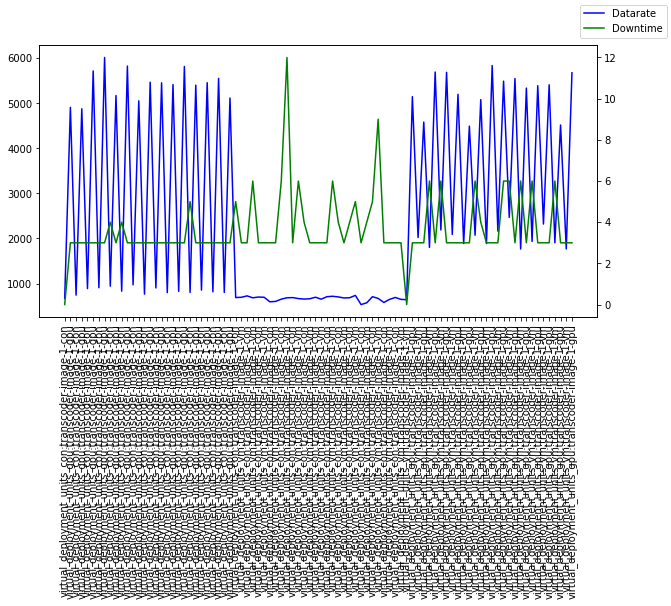

In [29]:
fig, ax1 = plt.subplots(figsize=(10,5))
plt.xticks(rotation=90)

x = policy_trace.index
y1 = policy_trace['avg_datarate']
y2 = policy_trace['down_time']

ax2 = ax1.twinx()

ind = np.arange(len(x))
width = 0.35
# sns.set(style='whitegrid', palette='muted', font_scale=1.5)

# Bar
# rects1 = ax1.bar(ind - width/2, y1, width, label='Datarate',color = 'b')
# rects2 = ax2.bar(ind + width/2, y2, width, label='Downtime', color = 'g')

# Plot
ax1.plot(x, y1, 'g-', label='Datarate',color = 'b')
ax2.plot(x, y2, 'b-', label='Downtime', color = 'g')

ax1.set_xticks(ind)
ax1.set_xticklabels(policy_trace['pc_100'])

print(policy_trace['avg_datarate'].mean())
print(policy_trace['down_time'].sum())


fig.legend()
# fig = ax2.get_figure()
plt.show()

## 2. History Experiment

In [192]:
# TIMEBLOCK = 60
# TIMEBLOCK = 60

# Setting initial version and waiting
set_remote_version(history_trace['history'][0])
time.sleep(30)

for index_label, row_series in history_trace.iterrows():

    print("Running Experiment at: ", index_label, " For: ", row_series['history'])

    # Switch version on MANO
    set_remote_version(row_series['history'])

    manager = multiprocessing.Manager()
    return_dict = manager.dict()

    return_dict["bitrates"] = manager.list()
    return_dict["playing_time"] = 0
    return_dict["down_time"] = 0

    _runner = ExperimentClient()

    p = multiprocessing.Process(target=_runner.consume_stream_proc, args=(TIMEBLOCK, return_dict))
    p.start()

    p.join()

    print("\n####################")
    print(np.mean(return_dict["bitrates"]), return_dict["playing_time"], return_dict["down_time"])
    print("####################\n")

    p.terminate()

    ################
    # Store Results 
    ################
    history_trace.at[index_label , 'avg_datarate'] = np.mean(return_dict["bitrates"])
    history_trace.at[index_label , 'playing_time'] = return_dict["playing_time"]
    history_trace.at[index_label , 'down_time'] = return_dict["down_time"]

    clear_output(wait=True)

Running Experiment at:  143  For:  virtual_deployment_units_vm:transcoder-image-1-vm
Switch Version:  Done
Streaming just started...
State.Playing [] P: 0 D: 0
State.Playing [911.9258522987366] P: 1 D: 0
State.Playing [911.9258522987366, 743.4689998626709] P: 2 D: 0
State.Playing [911.9258522987366, 743.4689998626709, 747.8267550468445] P: 3 D: 0
State.Playing [743.4689998626709, 747.8267550468445, 746.5720772743225] P: 4 D: 0
State.Playing [747.8267550468445, 746.5720772743225, 746.4531660079956] P: 5 D: 0
State.Playing [746.5720772743225, 746.4531660079956, 743.7497973442078] P: 6 D: 0
State.Playing [746.4531660079956, 743.7497973442078, 746.1250424385071] P: 7 D: 0
State.Playing [743.7497973442078, 746.1250424385071, 788.2112860679626] P: 8 D: 0
State.Playing [746.1250424385071, 788.2112860679626, 689.7186040878296] P: 9 D: 0
State.Playing [788.2112860679626, 689.7186040878296, 738.9045357704163] P: 10 D: 0
State.Playing [689.7186040878296, 738.9045357704163, 740.8767938613892] P: 1

State.Playing [746.9227910041809, 724.3643999099731, 871.3178634643555] P: 99 D: 0
State.Playing [724.3643999099731, 871.3178634643555, 607.5640320777893] P: 100 D: 0
State.Playing [871.3178634643555, 607.5640320777893, 743.0419921875] P: 101 D: 0
State.Playing [607.5640320777893, 743.0419921875, 746.3065385818481] P: 102 D: 0
State.Playing [743.0419921875, 746.3065385818481, 744.6872591972351] P: 103 D: 0
State.Playing [746.3065385818481, 744.6872591972351, 721.2216854095459] P: 104 D: 0
State.Playing [744.6872591972351, 721.2216854095459, 744.7888255119324] P: 105 D: 0
State.Playing [721.2216854095459, 744.7888255119324, 745.9825277328491] P: 106 D: 0
State.Playing [744.7888255119324, 745.9825277328491, 746.5865612030029] P: 107 D: 0
State.Playing [745.9825277328491, 746.5865612030029, 743.2703971862793] P: 108 D: 0
State.Playing [746.5865612030029, 743.2703971862793, 742.2583103179932] P: 109 D: 0
State.Playing [743.2703971862793, 742.2583103179932, 746.3825941085815] P: 110 D: 0
St

State.Playing [746.1597919464111, 724.2950797080994, 746.7548847198486] P: 197 D: 0
State.Playing [724.2950797080994, 746.7548847198486, 889.3821835517883] P: 198 D: 0
State.Playing [746.7548847198486, 889.3821835517883, 594.5072174072266] P: 199 D: 0
State.Playing [889.3821835517883, 594.5072174072266, 744.1602945327759] P: 200 D: 0
State.Playing [594.5072174072266, 744.1602945327759, 723.9142060279846] P: 201 D: 0
State.Playing [744.1602945327759, 723.9142060279846, 746.6959953308105] P: 202 D: 0
State.Playing [723.9142060279846, 746.6959953308105, 746.6843724250793] P: 203 D: 0
State.Playing [746.6959953308105, 746.6843724250793, 745.8014488220215] P: 204 D: 0
State.Playing [746.6843724250793, 745.8014488220215, 747.7920055389404] P: 205 D: 0
State.Playing [745.8014488220215, 747.7920055389404, 720.8400368690491] P: 206 D: 0
State.Playing [747.7920055389404, 720.8400368690491, 745.5704212188721] P: 207 D: 0
State.Playing [720.8400368690491, 745.5704212188721, 744.3927526473999] P: 2

State.Playing [745.1524138450623, 724.6350049972534, 745.193362236023] P: 295 D: 0
State.Playing [724.6350049972534, 745.193362236023, 741.4299845695496] P: 296 D: 0
State.Playing [745.193362236023, 741.4299845695496, 739.5983934402466] P: 297 D: 0
State.Playing [741.4299845695496, 739.5983934402466, 747.6165294647217] P: 298 D: 0
State.Playing [739.5983934402466, 747.6165294647217, 741.8712973594666] P: 299 D: 0
State.Playing [747.6165294647217, 741.8712973594666, 747.2489476203918] P: 300 D: 0

####################
743.0751232306162 300 0
####################



In [216]:
history_trace = history_trace.drop('index', axis=1)
history_trace.to_csv('./data/{}_{}m_history_qos_results.csv'.format(EXPERIMENT_START_TIME, LOOK_AHEAD))
history_trace.head()

,history,avg_datarate,playing_time,down_time
0,virtual_deployment_units_con:transcoder-image-...,829.886071,300.0,0.0
1,virtual_deployment_units_gpu:transcoder-image-...,6548.036024,290.0,10.0
2,virtual_deployment_units_gpu:transcoder-image-...,6369.936994,300.0,0.0
3,virtual_deployment_units_gpu:transcoder-image-...,6651.827397,300.0,0.0
4,virtual_deployment_units_con:transcoder-image-...,1019.851535,290.0,10.0


KeyError: 'avg_datarate'

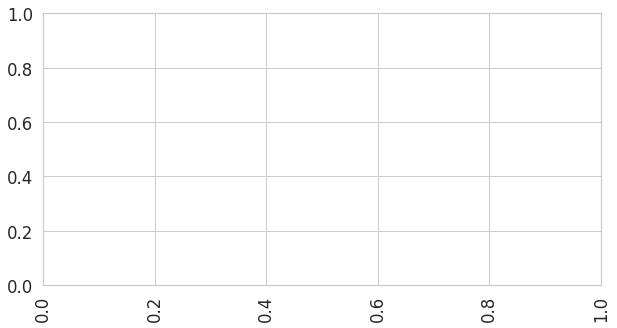

In [252]:
fig, ax1 = plt.subplots(figsize=(10,5))
plt.xticks(rotation=90)

x = history_trace.index
y1 = history_trace['avg_datarate']
y2 = history_trace['down_time']

ax2 = ax1.twinx()

ind = np.arange(len(x))
width = 0.35
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

# Bar
# rects1 = ax1.bar(ind - width/2, y1, width, label='Datarate',color = 'b')
# rects2 = ax2.bar(ind + width/2, y2, width, label='Downtime', color = 'g')

# Plot
ax1.plot(x, y1, 'g-', label='Datarate',color = 'b')
ax2.plot(x, y2, 'b-', label='Downtime', color = 'g')

ax1.set_xticks(ind)
ax1.set_xticklabels(history_trace['history'])

print(history_trace['avg_datarate'].mean())
print(history_trace['down_time'].sum())

fig.legend()
# fig = ax2.get_figure()
plt.show()

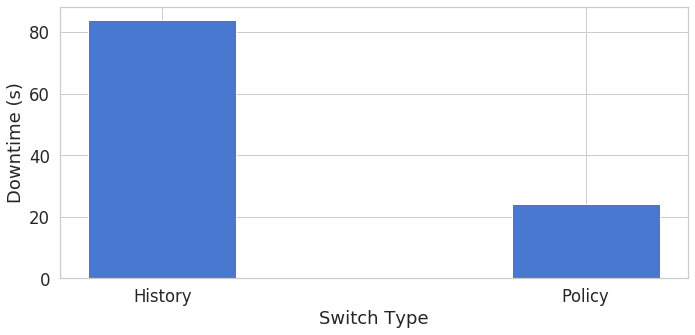

In [212]:
X_LABEL = 'Switch Type'
Y_LABEL = 'Downtime (s)'

down_time = [history_trace['down_time'].sum(), policy_trace['down_time'].sum()]

switch_type = ["History", "Policy"]

ind = np.arange(len(switch_type))
width = 0.35
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

fig, ax = plt.subplots(figsize=(10,5))

rects1 = ax.bar(ind, down_time, width, color = 'b')

# Labels, title and custom x-axis tick labels, etc.
ax.set_title('')

ax.set_xlabel(X_LABEL)
ax.set_ylabel(Y_LABEL)
ax.set_xticks(ind)
ax.set_xticklabels(switch_type)

# ax.legend()
fig.tight_layout()

# plt.show()